In [1]:
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import expon,uniform,randint

#Sklearn imports
from sklearn import linear_model
from sklearn.model_selection import train_test_split,RandomizedSearchCV,cross_val_score,cross_val_predict,validation_curve
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

%matplotlib inline

sensor_data=pd.read_csv('task_data.csv')
sensor_data.head()


,sample index,class_label,sensor0,sensor1,sensor2,sensor3,sensor4,sensor5,sensor6,sensor7,sensor8,sensor9
0,sample0,1.0,0.834251,0.726081,0.535904,0.214896,0.873788,0.767605,0.111308,0.557526,0.599650,0.665569
1,sample1,1.0,0.804059,0.253135,0.869867,0.334285,0.604075,0.494045,0.833575,0.194190,0.014966,0.802918
2,sample2,1.0,0.694404,0.595777,0.581294,0.799003,0.762857,0.651393,0.075905,0.007186,0.659633,0.831009
3,sample3,1.0,0.783690,0.038780,0.285043,0.627305,0.800620,0.486340,0.827723,0.339807,0.731343,0.892359
4,sample4,1.0,0.788835,0.174433,0.348770,0.938244,0.692065,0.377620,0.183760,0.616805,0.492899,0.930969


In [2]:
sensor_data.describe()
#Results shows clean data, imputation not required, on the same scale, normalization not required

,class_label,sensor0,sensor1,sensor2,sensor3,sensor4,sensor5,sensor6,sensor7,sensor8,sensor9
count,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000
mean,0.000000,0.523661,0.509223,0.481238,0.509752,0.497875,0.501065,0.490480,0.482372,0.482822,0.541933
std,1.001252,0.268194,0.276878,0.287584,0.297712,0.288208,0.287634,0.289954,0.282714,0.296180,0.272490
min,-1.000000,0.007775,0.003865,0.004473,0.001466,0.000250,0.000425,0.000173,0.003322,0.003165,0.000452
25%,-1.000000,0.299792,0.283004,0.235544,0.262697,0.249369,0.269430,0.226687,0.242848,0.213626,0.321264
50%,0.000000,0.534906,0.507583,0.460241,0.510066,0.497842,0.497108,0.477341,0.463438,0.462251,0.578389
75%,1.000000,0.751887,0.727843,0.734937,0.768975,0.743401,0.738854,0.735304,0.732483,0.740542,0.768990
max,1.000000,0.999476,0.998680,0.992963,0.995119,0.999412,0.997367,0.997141,0.998230,0.996098,0.999465


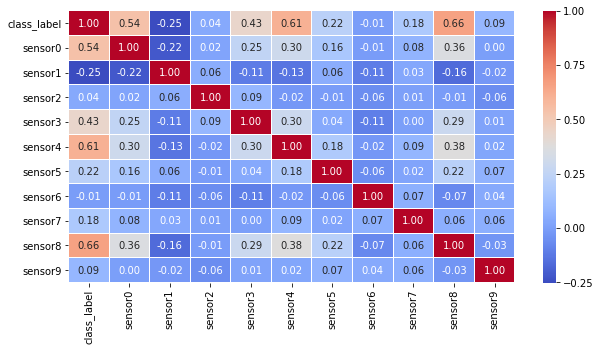

In [5]:
#Exploratory Stuff
#Correlations with the target variable
#Point Biserial Correlation since we have binary discrete target variable and continuous features

sensor_correlation=sensor_data.corr()
plt.subplots(figsize=(10,5))
sns.heatmap(sensor_correlation,xticklabels=sensor_correlation.columns.values,
            yticklabels=sensor_correlation.columns.values,annot=True,cmap="coolwarm",fmt="0.2f",linewidth=0.01)


In [6]:
#Another view of correlation of class_label with sensors
sensor_correlation['class_label'].sort_values(ascending=False)

class_label    1.000000
sensor8        0.660618
sensor4        0.607623
sensor0        0.543295
sensor3        0.433636
sensor5        0.224147
sensor7        0.175612
sensor9        0.094907
sensor2        0.038775
sensor6       -0.007414
sensor1       -0.252007
Name: class_label, dtype: float64

In [8]:
all_features=['sensor0','sensor1','sensor2','sensor3','sensor4','sensor5','sensor6','sensor7','sensor8','sensor9']
y=sensor_data['class_label']
x=sensor_data[all_features]
x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=0) #Basic train_test_split works here

print ("Shape of x_train: ", x_train.shape)
print ("Shape of y_train: ", y_train.shape)
print ("Shape of x_test: ", x_test.shape)
print ("Shape of y_test: ", y_test.shape)

#Data is well balanced between the 2 classes in both train/test
print ("\nValue counts for y_train:\n", y_train.value_counts())
print ("\nValue counts for y_test:\n", y_test.value_counts())

Shape of x_train:  (300, 10)
Shape of y_train:  (300,)
Shape of x_test:  (100, 10)
Shape of y_test:  (100,)

Value counts for y_train:
 -1.0    155
 1.0    145
Name: class_label, dtype: int64

Value counts for y_test:
  1.0    55
-1.0    45
Name: class_label, dtype: int64


In [9]:
#Checking the distribution of both train/test datasets
#Means/Std are almost the same for train.test set, they are well balanced
print ("\nx_train descriptive statistics:\n\n",x_train.agg([np.mean, np.std]))
print ("\nx_test descriptive statistics:\n\n",x_test.agg([np.mean, np.std]))


x_train descriptive statistics:

        sensor0   sensor1   sensor2   sensor3   sensor4   sensor5   sensor6  \
mean  0.511902  0.523074  0.476630  0.500287  0.499266  0.493760  0.488285   
std   0.268923  0.278430  0.290607  0.299196  0.291945  0.285576  0.286744   

       sensor7   sensor8   sensor9  
mean  0.483622  0.465155  0.558526  
std   0.282803  0.295358  0.265498  

x_test descriptive statistics:

        sensor0   sensor1   sensor2   sensor3   sensor4   sensor5   sensor6  \
mean  0.558937  0.467670  0.495063  0.538146  0.493703  0.522980  0.497067   
std   0.264187  0.269271  0.279291  0.292859  0.278085  0.294083  0.300758   

       sensor7   sensor8   sensor9  
mean  0.478621  0.535824  0.492154  
std   0.283837  0.293756  0.288140  


In [19]:
#Model Utility Functions

def classification_accuracy_report(actual,predicted):
    print ("\nAccuracy Score on Test Data: ", accuracy_score(actual,predicted))
    print ("\nConfusion Matrix on Test Data:\n", confusion_matrix(actual,predicted))
    print ("\nClassification Report on Test Data:\n",classification_report(actual,predicted))

    
def features_rank(feature_importance_coefficients,index_labels):
    feature_importance_coefficients=map(abs,feature_importance_coefficients)
    feature_with_coeff=zip(feature_importance_coefficients,index_labels)
    print ("\nFeatures and their importances:\n", feature_with_coeff)
    ranked_features=sorted(feature_with_coeff, key=lambda x: x[0],reverse=True)
    print ("\nRanked Features:\n", [elem[1] for elem in ranked_features])
    
    
def plot_validation_curve_decision_tree(train_scores,test_scores):
    #Citation: https://datascience.stackexchange.com/questions/26955/validation-curve-differs-from-cross-val-score
    param_range=np.arange(1, 50, 5)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.title("Validation Curve with Decision Tree Classifier")
    plt.xlabel("max_depth")
    plt.ylabel("Score")
    plt.ylim(0.0, 1.1)
    lw = 2
    plt.plot(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
    plt.plot(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
    plt.legend(loc="best")
    plt.show()

In [20]:
#First tring out a Linear Model, Logistic Regression with SGD Optimization using ElasticNet
#ElasticNet will help us select the right l1/l2 regularization hyper-parameter
#Using RandomizedSearchCV for near optimal hyper-parameter selection
#RandomizedSearchCV is not scalable but fine with the size of our samples
#Note that our main intent is ranking the features based on the model which gives decent accuracy
#As l1 regularization may result in sparse features, l2 will help us rank the features better for the tail

sgd_classifier=linear_model.SGDClassifier(max_iter=8000,penalty='elasticnet',random_state=42)
param_grid={'loss':['log','hinge','modified_huber'],'alpha':expon(scale=1),'l1_ratio':uniform(0,1)}
hyper_params_search_sgd=RandomizedSearchCV(estimator=sgd_classifier,param_distributions=param_grid,n_iter=5,random_state=42)
hyper_params_search_sgd.fit(x_train,y_train)

print ("FINDING NEAR OPTIMAL HYPER-PARAMETERS USING RANDOMIZED SEARCH FOR ELASTICNET LOGISTIC REGRESSION (log loss) USING STOCHASTIC GRADIENT DESCENT OPTIMIZER")
print ("\nBest Estimator:\n",hyper_params_search_sgd.best_estimator_)

y_test_pred = hyper_params_search_sgd.predict(x_test)
classification_accuracy_report(y_test,y_test_pred)


FINDING NEAR OPTIMAL HYPER-PARAMETERS USING RANDOMIZED SEARCH FOR ELASTICNET LOGISTIC REGRESSION (log loss) USING STOCHASTIC GRADIENT DESCENT OPTIMIZER

Best Estimator:
 SGDClassifier(alpha=0.16959629191460518, l1_ratio=0.05808361216819946,
              loss='log', max_iter=8000, penalty='elasticnet', random_state=42)

Accuracy Score on Test Data:  0.87

Confusion Matrix on Test Data:
 [[40  5]
 [ 8 47]]

Classification Report on Test Data:
               precision    recall  f1-score   support

        -1.0       0.83      0.89      0.86        45
         1.0       0.90      0.85      0.88        55

    accuracy                           0.87       100
   macro avg       0.87      0.87      0.87       100
weighted avg       0.87      0.87      0.87       100



In [22]:
#Approach-1
#Training using Linear Model
#Model: l2 Regularized Logistic Regression (log loss) using Stochatic Gradient Descent
#Taking few hyper-parameter from the output of the best estimator given by RandomizedSearchCV
#As we do not have enough validation data, using Cross-Validation for checking overfitting

sgd_classifier=linear_model.SGDClassifier(max_iter=10000,loss='log',penalty='l2',random_state=42)
scores=cross_val_score(sgd_classifier,x_train,y_train,cv=5)
print ("l2 REGULARIZED LOGISTIC REGRESSION (log loss) USING STOCHASTIC GRADIENT DESCENT OPTIMIZER\n")
print ("Cross Validation Scores on the training set: ", scores)

sgd_classifier.fit(x_train,y_train)
y_test_pred = sgd_classifier.predict(x_test)

classification_accuracy_report(y_test,y_test_pred)

coeff_list=list(itertools.chain(*sgd_classifier.coef_.tolist())) #Converting numpy array to list and then flattening
features_rank(coeff_list,all_features)

l2 REGULARIZED LOGISTIC REGRESSION (log loss) USING STOCHASTIC GRADIENT DESCENT OPTIMIZER

Cross Validation Scores on the training set:  [0.85       0.91666667 0.86666667 0.95       0.96666667]

Accuracy Score on Test Data:  0.88

Confusion Matrix on Test Data:
 [[35 10]
 [ 2 53]]

Classification Report on Test Data:
               precision    recall  f1-score   support

        -1.0       0.95      0.78      0.85        45
         1.0       0.84      0.96      0.90        55

    accuracy                           0.88       100
   macro avg       0.89      0.87      0.88       100
weighted avg       0.89      0.88      0.88       100


Features and their importances:

Ranked Features:
 ['sensor8', 'sensor4', 'sensor0', 'sensor3', 'sensor9', 'sensor7', 'sensor1', 'sensor6', 'sensor2', 'sensor5']


In [24]:
#Approach-3
#Lets try out a tree based classifier as well
#As there are 9-Dimensions there is a possibility of capturing a few relationships left by Linear Classifier
#Need to check the overfitting comprehensively here as Tree based Algorithms are prone to overfitting

print ("VANILLA DECISION TREES\n")

decision_tree=DecisionTreeClassifier()
scores=cross_val_score(decision_tree,x_train,y_train,cv=10)
print ("Cross Validation Scores on the training set: ", scores)

decision_tree=DecisionTreeClassifier(random_state=42).fit(x_train,y_train)
y_test_pred = decision_tree.predict(x_test)
classification_accuracy_report(y_test,y_test_pred)

coeff_list=decision_tree.feature_importances_
features_rank(coeff_list,all_features)



VANILLA DECISION TREES

Cross Validation Scores on the training set:  [0.96666667 1.         1.         0.93333333 0.93333333 0.93333333
 0.93333333 0.93333333 0.93333333 0.93333333]

Accuracy Score on Test Data:  0.97

Confusion Matrix on Test Data:
 [[44  1]
 [ 2 53]]

Classification Report on Test Data:
               precision    recall  f1-score   support

        -1.0       0.96      0.98      0.97        45
         1.0       0.98      0.96      0.97        55

    accuracy                           0.97       100
   macro avg       0.97      0.97      0.97       100
weighted avg       0.97      0.97      0.97       100


Features and their importances:

Ranked Features:
 ['sensor8', 'sensor6', 'sensor0', 'sensor1', 'sensor7', 'sensor2', 'sensor3', 'sensor4', 'sensor5', 'sensor9']


In [ ]:
# ---------- INTERNSHIP WEEK 2 TASK 1
# Try out plain LogisticRegressionClassifier - https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
# Try using an Ensemble of Decision Trees - https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
# OR try out any classifier
# Also print the feature importances from your clasifier like the one's printed above
# Is there some link between feature importance based on Tree Algorithms and correlation matrix at the top?
